# Theodor Jonsson Lab 4
I used code from [Chollet Chapter 6.2](https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/6.2-understanding-recurrent-neural-networks.ipynb) as a blueprint when conducting this laboration.

In [60]:
#!pip install tf-nightly
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# from tensorflow import keras
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Dropout, Activation, Add, LSTM, GRU, Dense,Input
from keras.layers import Embedding, SimpleRNN
from keras.utils  import to_categorical, plot_model, Sequence
# Keras dataset imports
from tensorflow.data import Dataset
from keras.datasets import imdb
from keras.preprocessing import sequence
# Optimizers
# Check if macos system
from keras.optimizers import RMSprop, Adagrad, SGD

# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

# print('Keras version:',tf.keras.__version__)

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# Helper libraries
import os
import datetime

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import IPython
import IPython.display
import seaborn as sns
# Typing imports for type hints / readability
from typing import Tuple, List, Dict, Any, Union
# NOTE: Fix the seed for reproducability
import os
import sys
np.random.seed(0)
tf.random.set_seed(0)
SENTIMENT = {
    1:"POSITIVE",
    0:"NEGATIVE"
}
batch_size = 128
def threshold(pred,thresh=0.5):
  return pred>thresh
word_index = imdb.get_word_index()
index_from = 3
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# def translate(x:np.ndarray):
  

TensorFlow version: 2.14.0-dev20230508


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb_word_index.json: None -- [Errno 8] nodename nor servname provided, or not known

In [47]:
# Test for GPU and determine what GPU we have
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
  !nvidia-smi -L

# If possible to run code wiht 16 bits float instad of 32 bits float, this code acitvates such functionality:
if gpu_devices:
 details = tf.config.experimental.get_device_details(gpu_devices[0])
#  compute_capability=details.get('compute_capability')
#  print("Compute capability:",compute_capability)
#  if compute_capability[0]>6:
#    print("Turning on mixed_float16")
#    policy = tf.keras.mixed_precision.Policy('mixed_float16')
#    tf.keras.mixed_precision.set_global_policy(policy)

zsh:1: command not found: nvidia-smi


# Part a) Understanding Embeddings
In the first part of the lab we shall get a deeper understanding of what the word embeddings are and how they can be used to represent language. To do this I'll use the [GenSim](https://radimrehurek.com/gensim/) moodel to generate a 300 dimensional representation of a word.

In [48]:
import gensim.downloader as api
from gensim.models import KeyedVectors
if not os.path.exists("mywordvecs.kvmodel"):
    wv = api.load('word2vec-google-news-300')
else:
    wv = KeyedVectors.load("mywordvecs.kvmodel", mmap='r')
# wv.save("mywordvecs.kvmodel")




In [49]:
vec = wv["hello"]
emb_shape = vec.shape
emb_dims = emb_shape[-1]
print(f"The embedding shape of a word using GenSim: {emb_shape}")

The embedding shape of a word using GenSim: (300,)


## Similarities
Experimenting with the similarites of different words.


In [50]:
ws = ['father',
      'mother',
      'man',
      'woman',
      'orange',
      'pink',
      'blue',
      'stupid',
      'smart',
      'gullible',
      'sports',
      'makeup',
      'fish',
      'table']
print("Similarity")
for i,w1 in enumerate(ws):
  for w2 in ws[i+1:]:
    print(f"{' '*2}\'{w1}\' - \'{w2}\' {wv.similarity(w1,w2):3.3f}")
  print("\n")

Similarity
  'father' - 'mother' 0.790
  'father' - 'man' 0.420
  'father' - 'woman' 0.377
  'father' - 'orange' 0.047
  'father' - 'pink' 0.024
  'father' - 'blue' 0.073
  'father' - 'stupid' 0.133
  'father' - 'smart' 0.059
  'father' - 'gullible' 0.048
  'father' - 'sports' 0.083
  'father' - 'makeup' 0.003
  'father' - 'fish' 0.081
  'father' - 'table' 0.010


  'mother' - 'man' 0.403
  'mother' - 'woman' 0.608
  'mother' - 'orange' 0.083
  'mother' - 'pink' 0.179
  'mother' - 'blue' 0.104
  'mother' - 'stupid' 0.147
  'mother' - 'smart' 0.042
  'mother' - 'gullible' 0.054
  'mother' - 'sports' -0.000
  'mother' - 'makeup' 0.055
  'mother' - 'fish' 0.107
  'mother' - 'table' 0.042


  'man' - 'woman' 0.766
  'man' - 'orange' 0.100
  'man' - 'pink' 0.063
  'man' - 'blue' 0.211
  'man' - 'stupid' 0.212
  'man' - 'smart' 0.092
  'man' - 'gullible' 0.119
  'man' - 'sports' 0.083
  'man' - 'makeup' 0.052
  'man' - 'fish' 0.151
  'man' - 'table' 0.049


  'woman' - 'orange' 0.069
  'woma

### Similarity Analysis
We can see that the some words we expect to be similar such as; "Man" - "Father", "Woman" - "Mother" & "Blue" - "Pink" - "Orange". Are similar according to the their vector representation. We also see that distant words such as; "Orange" - "Gullible", "Sports" - "Fish" & "Man" - "Table" are dissimilar.

## Similarity correlations
We shall explore some ways to move around in the vector space. This can be done easily using the most similar to the result of the following operations:
Let $\vec{A}, \vec{B} \; \& \; \vec{C}$ be vector embeddings of three different words A, B & C. Then a new words D with embedding $\vec D$ may be found as the most similar vector embedding from the following operation.

$$ \vec{A}+(\vec{B}-\vec{C}) ≈ \vec{D}$$

We shall select B and C such that we may predict the word D in advance to see if the model behaves as we expect it to.
This can be seen as a optimization problem of the following structure:

$$ \min_{j\in[1,2,..,N]} \left|\left| \vec{A}+(\vec{B}-\vec{C})-\vec{D_j}\right|\right|$$

Where $\vec{D_j}$ is the embedding of entry $j$ of the models vocabulary.
During this laboration we tested the following simple yet showing example.

| Index | Selection | Description |
|---|---|---|
| A | Sweden | Country of Sweden|
| B | Paris | Capital of the country France|
| C | France | Country of France|
| $\hat{\text{D}}$ | Stockholm | The expected result should be the capital of Sweden |

The mathematical interpertation of this operation would be that we take a step of $\vec{B}-\vec{C}$ in vector space from $\vec A$ in our case the difference between 'Paris' and 'France' would be that of the meaning of 'Capital'. Adding this to A, our staring point 'Sweden', one would expect the resutling word to be 'Stockholm'.

Using the `most_similar` function of the **GenSim** model. Along with keyowrd `positive` for A and B and `negative` for C. Which resulted in the following:







In [51]:
print(wv.most_similar(positive=['Sweden', 'Paris'], negative=['France'],topn=2))

[('Stockholm', 0.7852394580841064), ('Stockholm_Sweden', 0.6674871444702148)]


As we expected we recieved the capital of Sweden.

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [52]:
from keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [53]:
# Using inspiration  from https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow 
# To easily convert the GenSim.KeyedVectors into a keras Embedding layer
# To test the use of a pretrained embedding layer.

def gensim_to_keras_embedding(keyed_vectors, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [54]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [56]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328320 (1.25 MB)
Trainable params: 328320 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [58]:
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)
# Create datasets instead
train_ds = Dataset.from_tensor_slices((input_train,y_train))
test_ds = Dataset.from_tensor_slices((input_test,y_test))



Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [59]:
def show_predictions(model:Model,test_ds:Dataset,n=6):
  print(f"Model test predictions")
  print(f"INPUT - LABEL - PREDICTION")
  for (x,y) in test_ds.take(n):
    x = x if len(x.shape) >= 2 else np.expand_dims(x,axis=0)
    pred = model.predict(x)
    pred = threshold(pred)
    pred = SENTIMENT(pred)
    y = SENTIMENT(y)
    
    print(f"{' '*3}\'{x}\' - {y} - {pred}")
show_predictions(model,test_ds,1)



Model test predictions
INPUT - LABEL - PREDICTION
1/1 [==============================] - 67s 67s/step


UnboundLocalError: local variable 'pred' referenced before assignment

In [ ]:
def compile_and_fit(model:Model, train_ds,patience=3,epochs:int=10):
    loss_func = tf.losses.BinaryCrossEntropy()
    optimizer = tf.optimizers.legacy.Adam(learning_rate=0.001)
    early_stopping = EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights = True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6) 
    callbacks = [early_stopping,reduce_lr]
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=["accuracy"])

    history = model.fit(train_ds, epochs=epochs,
                        validation_split=0.2,
                        callbacks=callbacks)
    return history, model

def fit_and_evaluate_model(model:Model,train_ds,test_ds,patience=3,shift:int=1,epochs:int=10):
    history, model = compile_and_fit(model,train_ds=train_ds,patience=patience)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print('Test loss: %.3f' % test_loss)
    print('Test accuracy: %.3f' % test_acc)
    # Plot the training curves
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.show()
    show_predictions(model=model,data=test_ds,n=6)
    return history, model, test_loss, test_acc


In [32]:

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history_SimpleRNN = model.fit(input_train, y_train,
#                     epochs=10,
#                     batch_size=128,
#                     validation_split=0.2,
#                     callbacks=callbacks)

In [ ]:
def plot_history(history):
  # Plot the history trainig and validation history.
  # This includes the metrics and the loss.
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Let's display the training and validation loss and accuracy:

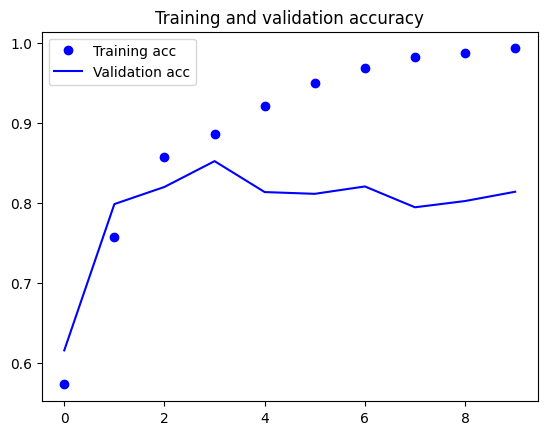

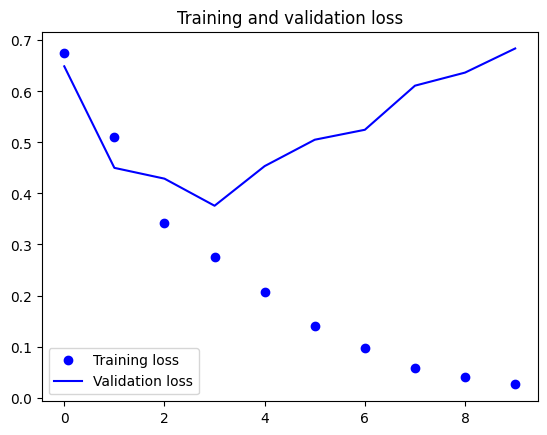

In [ ]:
plot_history(history_SimpleRNN)

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_LSTM = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
plot_history(history_LSTM)